# Libraries Import

In [1]:
import pandas as pd

# for connection with Azure SQL Database
import pyodbc
import urllib
import sqlalchemy

# for keeping credentials out of sight
import os
from dotenv import load_dotenv

# Credentials and Authorization

You will need to insert your database connection parameters and save as `sql-keys.env` local file.

```
DB_SERVER = "XXXXX"
DB_NAME = "XXXXX" 
DB_USERNAME = "XXXXX"
DB_PASSWORD = XXXXX
```
The following is the list of the connection parameters:
- *DB_SERVER*: database server address e.g., localhost or an IP address.
- *DB_NAME*: the name of the database that you want to connect.
- *DB_USERNAME*: the username used to authenticate.
- *DB_PASSWORD*: password used to authenticate.


In [2]:
# establish working directory path
# getcwd() returns current working directory
wdir_path = os.getcwd()

sql_path = os.path.join(wdir_path, "sql-keys.env") # absolute path of "sql-keys.env"
# load the credentials into os environment 
load_dotenv(sql_path)
# check if credentials loaded successfully
os.environ

# getting credentials information from "sql-keys.env"
server = os.getenv("DB_SERVER")
database = os.getenv("DB_NAME")
username = os.getenv("DB_USERNAME")
password = os.getenv("DB_PASSWORD")

driver = ''
# retriving ODBC Driver information from user's computer using Pyodbc
driver_names = [x for x in pyodbc.drivers() if x.endswith(' for SQL Server')]
if driver_names:
    driver = driver_names[0]

# Connection to Database

In [3]:
try:
    # if driver exists, create connection with Azure SQL Database
    if driver:
        conn_string = "DRIVER={" + driver + "};SERVER=" + server + ";DATABASE=" + database + ";UID=" + username + ";PWD=" + password
        
        # establish the connection
        
        # According to SQLAlchemy's documentation, an exact PyODBC connection string can be
        # sent in pyodbc's format directly using the parameter odbc_connect.
        # As the delimiters need to be URL-encoded (especially the Driver), urllib.parse.quote_plus is used
        # to encode the PyODBC connection string.
        db_params = urllib.parse.quote_plus(conn_string)
        engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(db_params), fast_executemany=True)
        
        cnxn = engine.raw_connection()

        # create a cursor object
        cursor = cnxn.cursor()

        print("Connection to database created successfully.")
    else:
        print("No suitable driver found. Cannot connect.")
except Exception as e:
    print("Connection could not be made due to the following error: \n", e)

Connection to database created successfully.


# Create Tables into Database

In [4]:
def create_table(command, msg):
    '''
    Function to create table into Azure database
    
    Parameters:
        command (string): SQL statement to create new table in database
        msg (string): A string message to print that table is successfully created
    '''
    try:
        cursor.execute(command)
        cnxn.commit()     
    except Exception as e:
        # rollback current transaction if there is an error
        cnxn.rollback()
        raise e
    print(msg)

# create olist_sellers table
create_table("""
            IF OBJECT_ID('dbo.olist_sellers', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_sellers
                (
                    seller_id VARCHAR(255) PRIMARY KEY NOT NULL, 
                    seller_zip_code_prefix INT, 
                    seller_city VARCHAR(255), 
                    seller_state VARCHAR(2)
                )
            END;
            """,
            "olist_sellers successfully created.")

# create olist_customers table
create_table("""
            IF OBJECT_ID('dbo.olist_customers', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_customers 
                (
                    customer_id VARCHAR(255) PRIMARY KEY NOT NULL,
                    customer_unique_id VARCHAR(255) NOT NULL, 
                    customer_zip_code_prefix INT, 
                    customer_city VARCHAR(255), 
                    customer_state VARCHAR(2)
                )
            END;
            """,
            "olist_customers successfully created.")

# create olist_geolocation
create_table("""
            IF OBJECT_ID('dbo.olist_geolocation', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_geolocation 
                (
                    geolocation_zip_code_prefix INT PRIMARY KEY NOT NULL,
                    geolocation_lat DECIMAL NOT NULL, 
                    geolocation_lng DECIMAL NOT NULL
                )
            END;
            """,
            "olist_geolocation successfully created.")

# create olist_orders_items
create_table("""
            IF OBJECT_ID('dbo.olist_orders_items', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_orders_items
                (
                    order_id VARCHAR(34) PRIMARY KEY NOT NULL,
                    order_item_id TINYINT,
                    product_id VARCHAR(34),
                    seller_id VARCHAR(34),
                    shipping_limit_date DATETIME,
                    price DECIMAL(9,2),
                    freight_value DECIMAL(9,2)
                )
            END;
            """,
            "olist_orders_items successfully created.")

# create olist_orders
create_table("""
            IF OBJECT_ID('dbo.olist_orders', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_orders
                (
                    order_id VARCHAR(34) PRIMARY KEY NOT NULL,
                    customer_id VARCHAR(34),
                    order_status VARCHAR(13),
                    order_purchase_timestamp DATETIME,
                    order_approved_at DATETIME,
                    order_delivered_carrier_date DATETIME,
                    order_delivered_customer_date DATETIME,
                    order_estimated_delivery_date DATETIME
                )
            END;
            """,
            "olist_orders successfully created.")

# create olist_order_reviews
create_table("""
            IF OBJECT_ID('dbo.olist_order_reviews', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_order_reviews
                (
                    review_id VARCHAR(34),
                    order_id VARCHAR(34) PRIMARY KEY NOT NULL,
                    review_score TINYINT,
                    review_creation_date DATETIME,
                    review_answer_timestamp DATETIME
                )
            END;
            """,
            "olist_order_reviews successfully created.")

# create olist_order_payments
create_table("""
            IF OBJECT_ID('dbo.olist_order_payments', 'U') IS NULL 
            BEGIN
                CREATE TABLE olist_order_payments
                (
                    order_id VARCHAR(34) PRIMARY KEY NOT NULL,
                    payment_sequential TINYINT,
                    payment_type VARCHAR(34),
                    payment_installments TINYINT,
                    payment_value DECIMAL(9,2)
                )
            END;
            """,
            "olist_order_payments successfully created.")

olist_sellers successfully created.
olist_customers successfully created.
olist_geolocation successfully created.
olist_orders_items successfully created.
olist_orders successfully created.
olist_order_reviews successfully created.
olist_order_payments successfully created.


# Data Cleaning

In [5]:
def dataframe_summary(df):
    print("Rows:", df.shape[0], "Columns:", df.shape[1])

    # determine the number of unique values in each column
    print("\nNumber of unique values in each column:")
    print(df.nunique(axis=0))

    # determine the number of null values
    print("\nNumber of NULL values in each column:")
    print(df.isna().sum())

### Customers data

The `olist_customers_dataset` contains location informations of the customer.
- `customer_unique_id` is a unique id identifying customers in the system. It is an id generated at the time of **signup**.
- `customer_id` is a temporary id generated everytime the customer places an order.

In [6]:
# import dataset
cust_df = pd.read_csv("data/olist_customers_dataset.csv")

# view dataset
cust_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
dataframe_summary(cust_df)

Rows: 99441 Columns: 5

Number of unique values in each column:
customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

Number of NULL values in each column:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


### Sellers data

The `olist_sellers_dataset` contains locations information of the sellers in terms of zip code, city and state. The sellers list their products on the website and are then responsible for dispatching the delivery.

In [8]:
# import dataset
seller_df = pd.read_csv("data/olist_sellers_dataset.csv")

# view dataset
seller_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [9]:
dataframe_summary(seller_df)

Rows: 3095 Columns: 4

Number of unique values in each column:
seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

Number of NULL values in each column:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


### Geolocation data

The `olist_geolocation_dataset` contains latitude and longitude points, city and state for the zipcodes.

In [144]:
# import dataset
geo_df = pd.read_csv('data/olist_geolocation_dataset.csv')

# view dataset
geo_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [145]:
dataframe_summary(geo_df)

Rows: 1000163 Columns: 5

Number of unique values in each column:
geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

Number of NULL values in each column:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64


There are 19.051 different `geolocation_zip_code_prefix`. On average there are 52.6 coordinates for each zipcode. And there is even one zipcode with 1146 coordinates available.

In [146]:
geo_df['geolocation_zip_code_prefix'].value_counts().to_frame().describe()

,geolocation_zip_code_prefix
count,19015.000000
mean,52.598633
std,72.057907
min,1.000000
25%,10.000000
50%,29.000000
75%,66.500000
max,1146.000000


Mapping the latitudes and longtitudes of the geolocation dataset on a world map, we can observe that there are some outliers coordinates in the dataset that are outside of Brazilian territory.

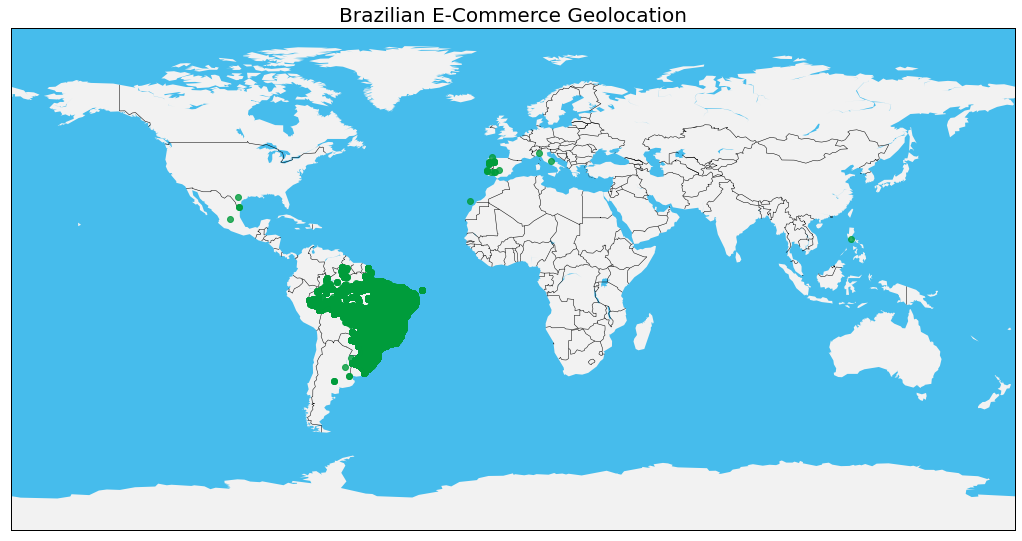

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

lat = geo_df['geolocation_lat']
lon = geo_df['geolocation_lng']

plt.figure(figsize=(18,18))

m = Basemap()
m.bluemarble()
m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
m.drawcountries()
m.scatter(lon, lat,zorder=10,alpha=0.8,color='#009c3b')
plt.title(label='Brazilian E-Commerce Geolocation', fontsize=20)
plt.show()

Lets guarantee that all coordinates are within a rectangle delimited by the limits of Brazil.

In [148]:
# Removing some outliers
# Brazil's most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_df = geo_df[geo_df.geolocation_lat <= 5.27438888]
# Brazil's most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_df = geo_df[geo_df.geolocation_lng >= -73.98283055]
# Brazil's most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_df = geo_df[geo_df.geolocation_lat >= -33.75116944]
# Brazli's most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_df = geo_df[geo_df.geolocation_lng <=  -34.79314722]

That's more like it.

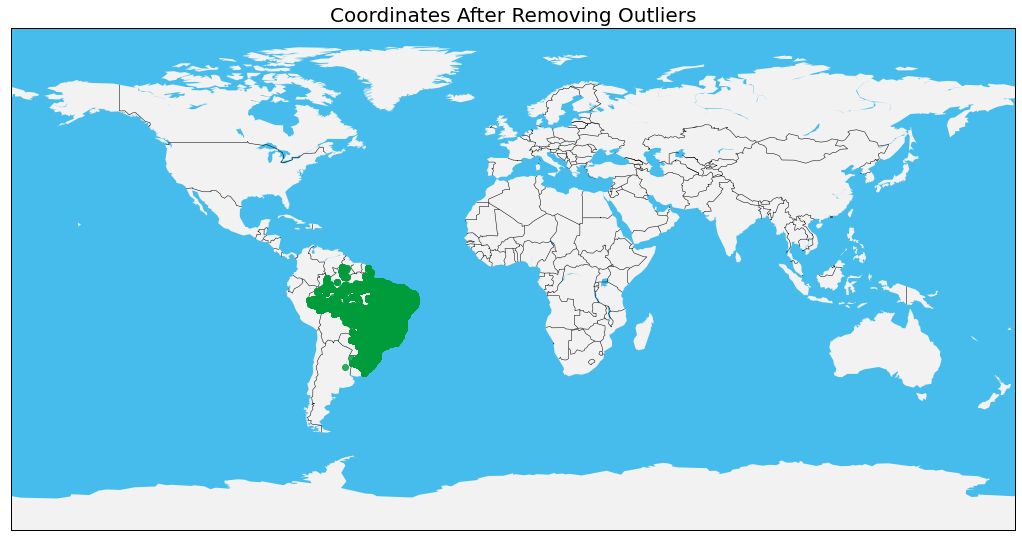

In [149]:
lat_cleaned = geo_df['geolocation_lat']
lon_cleaned = geo_df['geolocation_lng']

plt.figure(figsize=(18,18))

m = Basemap()
m.bluemarble()
m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
m.drawcountries()
m.scatter(lon_cleaned, lat_cleaned,zorder=10,alpha=0.8,color='#009c3b')
plt.title(label='Coordinates After Removing Outliers', fontsize=20)
plt.show()

Now we need to clean up the coordinates for duplicated zipcodes.

In [150]:
geo_df[geo_df['geolocation_zip_code_prefix'] == 1046]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
15,1046,-23.546081,-46.644820,sao paulo,SP
19,1046,-23.545884,-46.643163,sao paulo,SP
20,1046,-23.545166,-46.643786,sao paulo,SP
...,...,...,...,...,...
1432,1046,-23.545166,-46.643786,sao paulo,SP
1437,1046,-23.547191,-46.642923,sao paulo,SP
1439,1046,-23.545158,-46.643880,sao paulo,SP
1450,1046,-23.545292,-46.643130,sao paulo,SP


Let's find a location in longtitude and latitude for zipcode! And since every customers and sellers in the `olist_customers_dataset` and `olist_sellers_dataset` has a zipcode associated as their location within the city and state, we will be dropping `geolocation_city` and `geolocation_state`.

In [151]:
geo_df = geo_df.groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']].mean().reset_index()

geo_df[geo_df['geolocation_zip_code_prefix'] == 1046]

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
45,1046,-23.54593,-46.643998


In [152]:
geo_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
0,1001,-23.550190,-46.634024
1,1002,-23.548146,-46.634979
2,1003,-23.548994,-46.635731
3,1004,-23.549799,-46.634757
4,1005,-23.549456,-46.636733


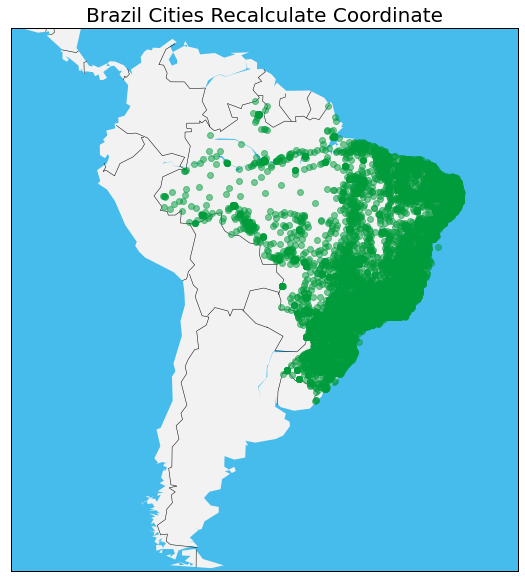

In [153]:
lat_recalculated = geo_df['geolocation_lat']
lon_recalculated = geo_df['geolocation_lng']

plt.figure(figsize=(10,10))

import numpy as np

m = Basemap(llcrnrlat=-55.401805,llcrnrlon=-92.269176,urcrnrlat=13.884615,urcrnrlon=-27.581676)
m.bluemarble()
m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
#]m.drawcoastlines()
m.drawcountries()
m.scatter(lon_recalculated, lat_recalculated, zorder=10, alpha=0.5, color='#009c3b')
plt.title(label='Brazil Cities Recalculate Coordinate', fontsize=20) # add a title
plt.show()

### Order items data
The `olist_order_items_dataset` contains IDs of the order, order item, product, & seller. Also contains shipping limit date, price, and freight value.

In [14]:
# import dataset
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')

# view dataset
order_items_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [15]:
dataframe_summary(order_items_df)

Rows: 112650 Columns: 7

Number of unique values in each column:
order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Number of NULL values in each column:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


### Orders data
The `olist_orders_dataset` contains customer ID and information about the orders consisting of ID, status, various time and date information like purchase and estimated delivery.

In [16]:
# import dataset
orders_df = pd.read_csv('data/olist_orders_dataset.csv')

# view dataset
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [17]:
dataframe_summary(orders_df)

Rows: 99441 Columns: 8

Number of unique values in each column:
order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

Number of NULL values in each column:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


### Order Reviews

In [18]:
# Read in olist_order_reviews_dataset.csv as pandas dataframe and parse dates of 
# "review_creation_date" and "review_answer_timestamp" columns.
parse_dates = ["review_creation_date", "review_answer_timestamp"]
reviews_df = pd.read_csv("data/olist_order_reviews_dataset.csv",\
                                 infer_datetime_format = True, parse_dates = parse_dates, encoding='latin-1')

# Drop duplicates from review_id column.
reviews_df.drop_duplicates(subset = ['review_id'], inplace = True)

# Preview the first 5 lines of the loaded data 
reviews_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,ParabÃ©ns lojas lannister adorei comprar pela ...,2018-03-01,2018-03-02 10:26:53


In [19]:
# Count number of entries in each column
reviews_df.count()

review_id                  99173
order_id                   99173
review_score               99173
review_comment_title       11665
review_comment_message     41431
review_creation_date       99173
review_answer_timestamp    99173
dtype: int64

In [20]:
# Count number of unique entries
reviews_df.nunique()

review_id                  99173
order_id                   98926
review_score                   5
review_comment_title        4600
review_comment_message     36921
review_creation_date         637
review_answer_timestamp    99010
dtype: int64

In [21]:
# Check for null values
reviews_df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87508
review_comment_message     57742
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [22]:
# Drop columns with null values
reviews_df.drop(columns = ["review_comment_title", "review_comment_message"], inplace = True)

#Print dataframe
reviews_df.head()

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01,2018-03-02 10:26:53


In [23]:
# Change column to datetime
reviews_df['review_answer_timestamp'] = reviews_df['review_answer_timestamp'].dt.date

# Check data info
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   review_id                100000 non-null  object        
 1   order_id                 100000 non-null  object        
 2   review_score             100000 non-null  int64         
 3   review_creation_date     100000 non-null  datetime64[ns]
 4   review_answer_timestamp  100000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.8+ MB


In [24]:
# Change column to datetime
reviews_df['review_answer_timestamp'] = pd.to_datetime(reviews_df['review_answer_timestamp'])

# Print dataframe
reviews_df.dtypes

review_id                          object
order_id                           object
review_score                        int64
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object

### Order Payments
### Boleto payments: Boleto is an official (regulated by the Central Bank of Brazil) payment method in Brazil. 
### To complete a transaction, customers receive a voucher stating the amount to pay for services or goods. 
### Customers then pay the boleto before its expiration date in one of several different methods, including at authorized agencies or banks, ATMs, or online bank portals. 
### You will receive payment confirmation after 1 business day, while funds will be available for payout 2 business days after payment confirmation.
### https://stripe.com/docs/payments/boleto 
### https://www.rapyd.net/blog/what-is-boleto-everything-you-need-to-know/ 

In [25]:
# Read in olist_order_payments_dataset.csv and make pandas dataframe
payments_df = pd.read_csv("data\olist_order_payments_dataset.csv")

# Drop duplicates from order_id column
payments_df.drop_duplicates(subset = ['order_id'], inplace = True)

# Set index as order_id
payments_df.set_index("order_id", inplace = True)

# Print dataframe
payments_df.head()

,payment_sequential,payment_type,payment_installments,payment_value
order_id,,,,
b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [26]:
# Reset index for order_id to column
payments_df=payments_df.reset_index()

In [27]:
# Count rows of each column
payments_df.count()

order_id                99440
payment_sequential      99440
payment_type            99440
payment_installments    99440
payment_value           99440
dtype: int64

In [28]:
# Count number of unique entries
payments_df.nunique()

order_id                99440
payment_sequential         16
payment_type                5
payment_installments       24
payment_value           28133
dtype: int64

In [29]:
# Print dataframe
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [30]:
# Check for null values
payments_df.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [31]:
# Check datatypes
payments_df.dtypes

order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

# Insert into Azure SQL Database

In [32]:
def write_df(df_name, table_name, msg):
    '''
    Function to insert values from dataframe into Azure database
    
    Parameters:
        df_name: DataFrame name to get data from
        table_name (string): Table name to update in SQL Azure Database
        msg (string): A string message to print that table is successfully updated
    '''
    try:
        df_name.to_sql(table_name, engine, index=False, if_exists="replace", schema="dbo")
        cnxn.commit()     
    except Exception as e:
        # rollback current transaction if there is an error
        cnxn.rollback()
        raise e
    print(msg)

# insert data into olist_customers table
write_df(cust_df, "olist_customers", "olist_customers updated successfully.")
write_df(seller_df, "olist_sellers", "olist_sellers updated successfully.")
write_df(geo_df, "olist_geolocation", "olist_geolocation updated successfully.")
write_df(order_items_df, "olist_orders_items", "olist_orders_items updated successfully.")
write_df(orders_df, "olist_orders", "olist_orders updated successfully.")
write_df(reviews_df, "olist_order_reviews", "olist_order_reviews updated successfully.")
write_df(payments_df, "olist_order_payments", "olist_order_payments updated successfully.")

olist_customers updated successfully.
olist_sellers updated successfully.
olist_geolocation updated successfully.
olist_orders_items updated successfully.
olist_orders updated successfully.
olist_order_reviews updated successfully.
olist_order_payments updated successfully.


In [33]:
cursor.close()
cnxn.close()